**Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import groupby
%matplotlib inline

**Uploading cleaned CSV File and creating Dataframe**

In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [ ]:
data = pd.read_csv("1QBit_MSM_CL.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.tail()

,Futures Settlement Price,Futures Contract Year,Futures Contract Month,Next Futures Settlement Price,Next Futures Contract Year,Next Futures Contract Month
Date,,,,,,
2023-09-25,89.68,2023,11,88.17,2023,12
2023-09-26,90.39,2023,11,88.78,2023,12
2023-09-27,93.68,2023,11,91.30,2023,12
2023-09-28,91.71,2023,11,89.59,2023,12
2023-09-29,90.79,2023,11,88.80,2023,12


**Plotting current and next month futures price**

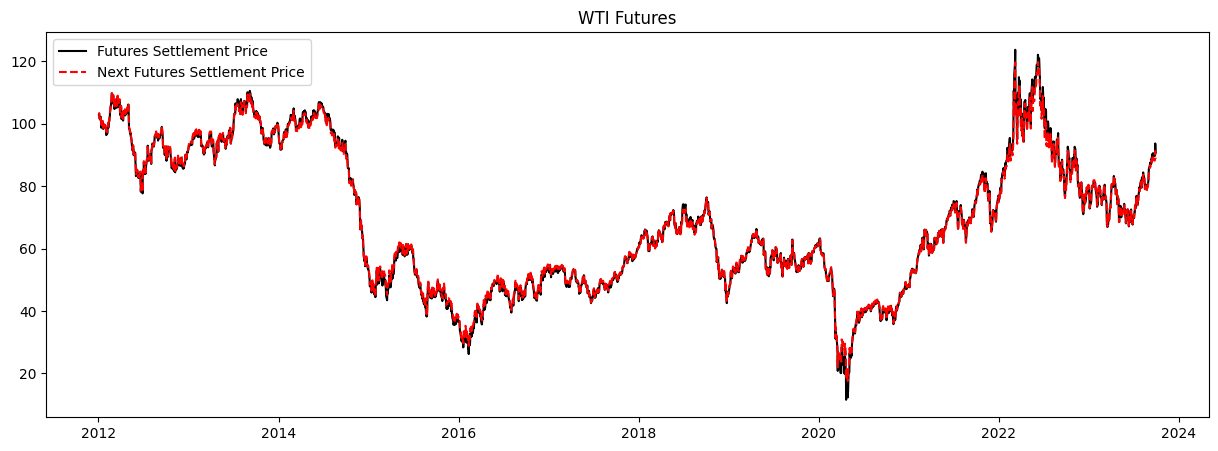

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(data['Futures Settlement Price'], label = "Futures Settlement Price", linestyle="-", color='black')
plt.plot(data['Next Futures Settlement Price'], label = "Next Futures Settlement Price", linestyle="--", color='red')
plt.title('WTI Futures')
plt.legend()
plt.show()

**Calculating the calendar spread, and creating a rolling mean and standard deviation for the same**

In [ ]:
data['Spread'] = data['Futures Settlement Price'] - data['Next Futures Settlement Price']

data['RollingMean'] = data['Spread'].rolling(20).mean()
data['RollingStdDev'] = data['Spread'].rolling(20).std()
data = data[20:]  # Skip the first 20 rows with NaN values

**Defining parameters and initializing positions**

In [ ]:
# Define entry and exit thresholds based on mean reversion strategy
entry_threshold = 1.0  # Entry when spread is 1 standard deviation away from the mean
exit_threshold = 0.5   # Exit when spread is 0.5 standard deviations away from the mean

# Initialize positions
long_position = 0
short_position = 0

# Lists to store trade signals and PnL
trade_signals = []
pnl = []
returns = []
capital_allocated = []

**Creating the trading strategy by combining mean reversion and calendar spread**

In [ ]:
for index, row in data.iterrows():
    if row['Spread'] < row['RollingMean'] - entry_threshold * row['RollingStdDev']:
        # Enter a long position
        long_position = 1
        short_position = 0
        trade_signals.append(1)  # Buy Open signal
        position_value = max(row['Next Futures Settlement Price'], row['Futures Settlement Price']) * 100
    elif row['Spread'] > row['RollingMean'] + entry_threshold * row['RollingStdDev']:
        # Enter a short position
        long_position = 0
        short_position = 1
        trade_signals.append(-1)  # Sell Open signal
        position_value = max(row['Next Futures Settlement Price'], row['Futures Settlement Price']) * 100

    elif long_position and row['Spread'] > row['RollingMean'] - exit_threshold * row['RollingStdDev']:
        # Exit the long position
        long_position = 0
        trade_signals.append(2)  # Sell Close signal
    elif short_position and row['Spread'] < row['RollingMean'] + exit_threshold * row['RollingStdDev']:
        # Exit the short position
        short_position = 0
        trade_signals.append(-2)  # Buy Close signal
    else:
        trade_signals.append(0)  # No trade

    # Calculate PnL based on the position (100 contracts per trade)
    if long_position:
        pnl.append(100 * (row['Next Futures Settlement Price'] - row['Futures Settlement Price']))
    elif short_position:
        pnl.append(100 * (row['Futures Settlement Price'] - row['Next Futures Settlement Price']))
    else:
        pnl.append(0)

    capital_allocated.append(position_value)
    returns = [p / c if c != 0 else 0 for p, c in zip(pnl, capital_allocated)]


**Adding the calculated parameters to the dataframe**

In [ ]:
data['Trade_Signal'] = trade_signals
data['PnL'] = pnl
data['Profit'] = (data['PnL']).cumsum()
data['CapitalAllocated'] = capital_allocated
data['Returns'] = returns
data['Cumulative Returns'] = (data['Returns']).cumsum()

data

,Futures Settlement Price,Futures Contract Year,Futures Contract Month,Next Futures Settlement Price,Next Futures Contract Year,Next Futures Contract Month,Spread,RollingMean,RollingStdDev,Trade_Signal,PnL,Profit,CapitalAllocated,Returns,Cumulative Returns
Date,,,,,,,,,,,,,,,
2012-02-01,97.61,2012,3,97.99,2012,4,-0.38,-0.2625,0.076149,1,38.0,38.0,9799.0,0.003878,0.003878
2012-02-02,96.36,2012,3,96.74,2012,4,-0.38,-0.2725,0.077858,1,38.0,76.0,9674.0,0.003928,0.007806
2012-02-03,97.84,2012,3,98.23,2012,4,-0.39,-0.2825,0.079530,1,39.0,115.0,9823.0,0.003970,0.011776
2012-02-06,96.91,2012,3,97.41,2012,4,-0.50,-0.2965,0.091667,1,50.0,165.0,9741.0,0.005133,0.016909
2012-02-07,98.41,2012,3,98.82,2012,4,-0.41,-0.3065,0.092638,1,41.0,206.0,9882.0,0.004149,0.021058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,89.68,2023,11,88.17,2023,12,1.51,0.8870,0.380832,-1,151.0,40483.0,8968.0,0.016838,7.600120
2023-09-26,90.39,2023,11,88.78,2023,12,1.61,0.9460,0.397352,-1,161.0,40644.0,9039.0,0.017812,7.617931
2023-09-27,93.68,2023,11,91.30,2023,12,2.38,1.0410,0.495165,-1,238.0,40882.0,9368.0,0.025406,7.643337


**Calculating Performance Metrics**

In [ ]:
# Calculate total profit
total_profit = data['Profit'].iloc[-1]

# Calculate annualized return
average_capital_allocated = data['CapitalAllocated'].mean()
total_return = data['Cumulative Returns'].iloc[-1] * 100
annualized_return = ((1 + total_return/100) ** (252 / len(data)) - 1) * 100

risk_free_rate = 3.50
sharpe_ratio = (annualized_return - risk_free_rate) / (data['PnL'].std())

# Calculate the maximum drawdown and calmar ratio
rolling_max = data['PnL'].cummax()
drawdown = (data['PnL'] - rolling_max) / rolling_max
max_drawdown = (drawdown.min() * 100 / average_capital_allocated) * 100

calmar_ratio = annualized_return / 100 * abs(max_drawdown)

# Calculate types of trades
num_buy_open = len([x for x in data['Trade_Signal'] if x == 1])
num_sell_close = len([x for x in data['Trade_Signal'] if x == 2])
num_sell_open = len([x for x in data['Trade_Signal'] if x == -1])
num_buy_close = len([x for x in data['Trade_Signal'] if x == -2])
num_no_trade = len([x for x in data['Trade_Signal'] if x == 0])

# Calculate win-loss ratio
num_winning_trades = len([x for x in data['PnL'] if x > 0])
num_losing_trades = len([x for x in data['PnL'] if x < 0])
total_trades = len(data[data['Trade_Signal'] != 0])

trade_durations = [len(list(group)) for key, group in groupby(data['Trade_Signal']) if key != 0]
average_trade_duration = np.mean(trade_durations)

**Display Performance Metrics**

In [ ]:
print(f'Total Profit: $ {round(total_profit, 2)}')
print(f'Average Capital Required: $ {round(average_capital_allocated, 2)}')
print(f'Total Return: {round(total_return, 2)} %')
print(f'Annualized Return: {round(annualized_return, 2)} %')
print(f'Sharpe Ratio: {round(sharpe_ratio, 2)}')
print(f'Calmar Ratio: {round(calmar_ratio, 2)}')
print(f'Max Drawdown: {round(max_drawdown, 2)} %')
print(f'Winning Trades: {round(100 * num_winning_trades / (num_winning_trades+num_losing_trades), 2)} %')
print(f'Total Number of Trades: {total_trades}')
print(f'Average Trade Duration: {round(average_trade_duration, 2)} days')
print(f'Buy Open: {round(num_buy_open, 2)}')
print(f'Sell Close: {round(num_sell_close, 2)}')
print(f'Sell Open: {round(num_sell_open, 2)}')
print(f'Buy Close: {round(num_buy_close, 2)}')
print(f'No Trade: {round(num_no_trade, 2)}')

Total Profit: $ 41293.0
Average Capital Required: $ 6914.83
Total Return: 768.84 %
Annualized Return: 20.37 %
Sharpe Ratio: 0.23
Calmar Ratio: 0.55
Max Drawdown: -2.71 %
Winning Trades: 57.85 %
Total Number of Trades: 1740
Average Trade Duration: 2.98 days
Buy Open: 711
Sell Close: 113
Sell Open: 789
Buy Close: 127
No Trade: 1198


# New section

**Plotting the Results**

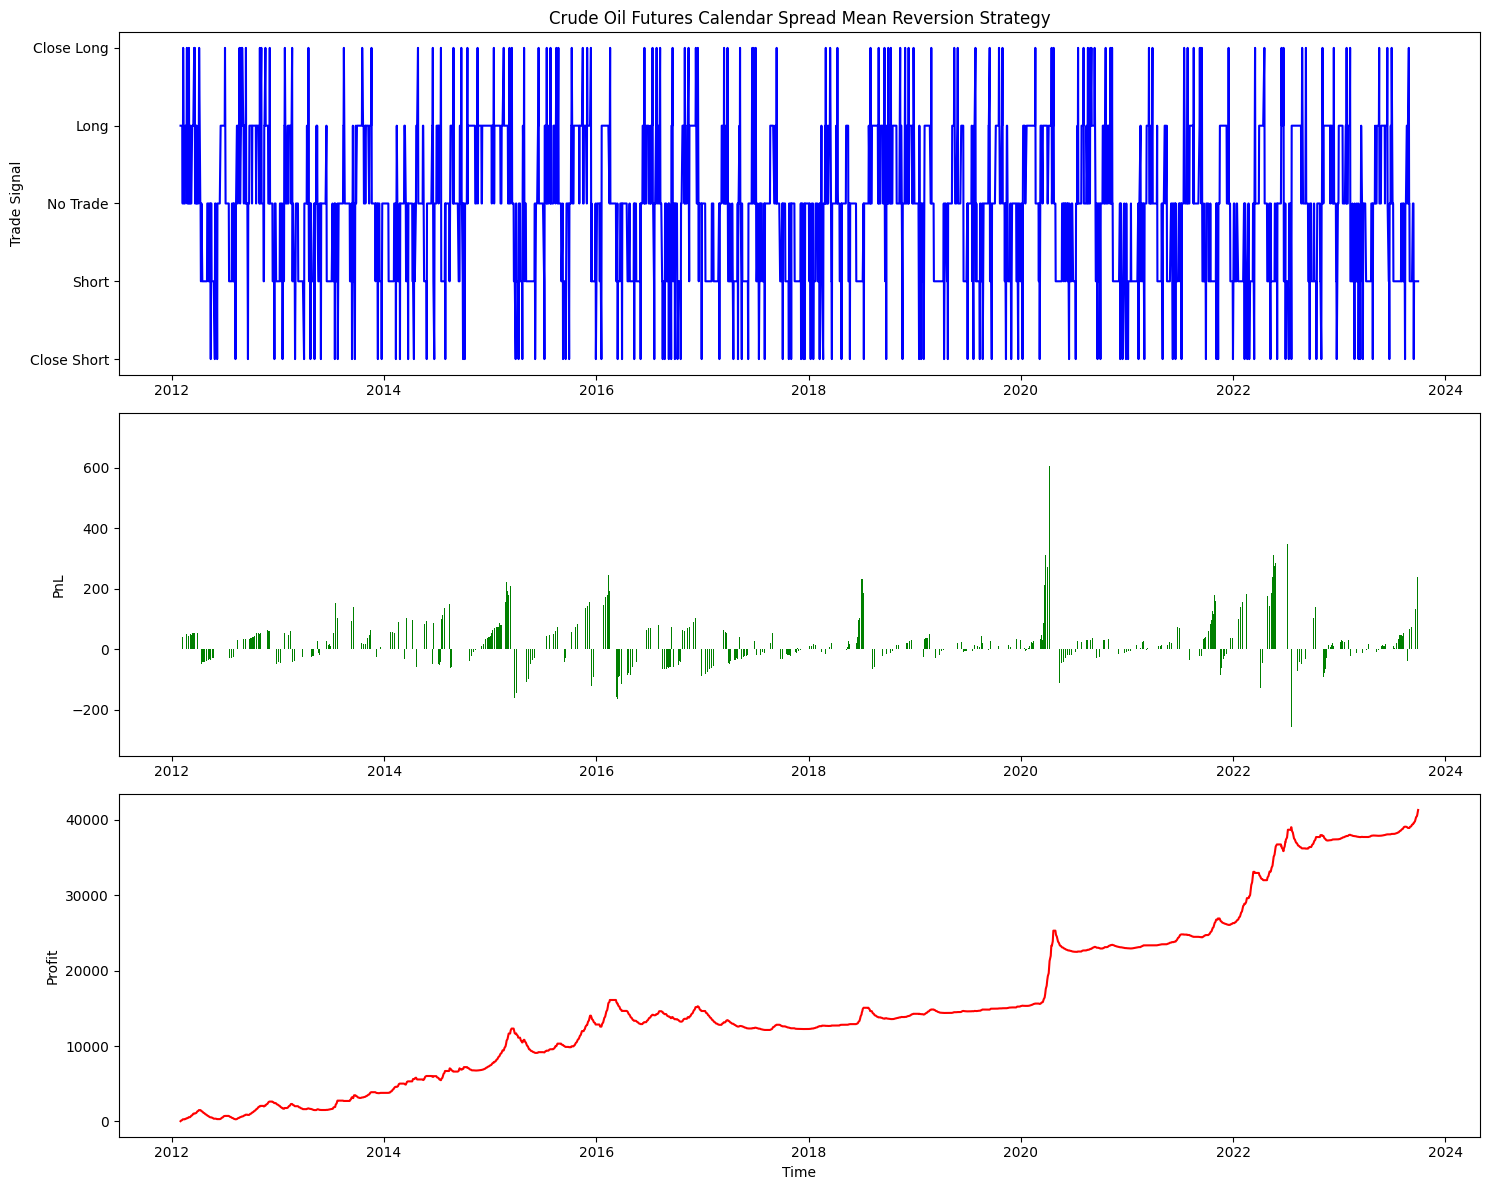

In [ ]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

# Plot the trade signal
ax1.plot(data.index, data['Trade_Signal'], label='Trade Signal', color='b')
ax1.set_ylabel('Trade Signal')
ax1.set_title('Crude Oil Futures Calendar Spread Mean Reversion Strategy')
ax1.set_yticks([-2,-1,0,1,2])
ytick_labels = ['Close Short','Short', 'No Trade', 'Long', 'Close Long']
ax1.set_yticklabels(ytick_labels)

# Plot PnL as a bar graph
ax2.bar(data.index, data['PnL'], label='PnL', color='g')
ax2.set_ylabel('PnL')

# Plot returns as a line graph
ax3.plot(data.index, data['Profit'], label='Profit', color='r')
ax3.set_xlabel('Time')
ax3.set_ylabel('Profit')

# Show the plots
plt.tight_layout()
plt.show()